# **Task1**

### **Stage -1:** _Importing libs_

In [1]:
from typing import Optional, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as mpl_axes
import sklearn as sl
import scipy
import seaborn as sns
import statsmodels.api as sm

### **Stage 0:** _Master-classes for data and graph processing_

##### **_Plotter_**

In [2]:
class Plotter:
    def __init__(self, nrows: int = 1, ncols: int = 1, figsize: Tuple[int, int] = (6, 6)) -> None:
        self.fig, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        self.nrows = 0
        self.ncols = 0
        
        if nrows == 1 and ncols == 1:
            self.axes = np.array([self.axes])
        elif nrows == 1 or ncols == 1:
            self.axes = self.axes.reshape(-1)
        else:
            self.axes = self.axes.flatten()

        self.position = None
    
    def __getitem__(self, index: int):
        return self._get_axes_by_index(index)
    
    def __getattr__(self, name: str):
        if hasattr(mpl_axes.Axes, name):
            def dynamic_method(*args, 
                             idx: Optional[int] = None,
                             irow: Optional[int] = None,
                             icol: Optional[int] = None,
                             **kwargs):
                ax = self._get_axis(idx, irow, icol) if self.position is None else self.position
                method = getattr(ax, name)
                return method(*args, **kwargs)
            
            return dynamic_method
        
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")
    
    def _get_axes_by_index(self, idx: int = 0) -> Any:
        return self.axes[idx]
    
    def _get_axes_by_coords(self, irow: int = 0, icol: int = 0) -> Any:
        idx = irow * self.ncols + icol
        return self.axes[idx]

    def _get_axis(self,
                  idx: Optional[int] = None,
                  irow: Optional[int] = None,
                  icol: Optional[int] = None) -> Any:
        if idx is not None:
            return self._get_axes_by_index(idx)
        elif irow is not None and icol is not None:
            return self._get_axes_by_coords(irow, icol)
        else:
            raise ValueError("ERROR: Wrong indexation!")
    
    def set_position(self,
                     idx: Optional[int] = None,
                     irow: Optional[int] = None,
                     icol: Optional[int] = None) -> None:
        
        self.position = self._get_axis(idx, irow, icol)
    
    def del_position(self) -> None:
        self.position = None
        
    def labels(self,
               xlabel: str,
               ylabel: str,
               title: str,
               idx: Optional[int] = None,
               irow: Optional[int] = None,
               icol: Optional[int] = None) -> Any:

        ax = self._get_axis(idx, irow, icol) if self.position is None else self.position
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        return ax

    def raincloud_plot(self, data, param_name, target_col_name, classes, colors,
                       idx: Optional[int] = None,
                       irow: Optional[int] = None,
                       icol: Optional[int] = None,
                       violin_offset: float = 0,
                       points_offset: float = -0.15,
                       box_offset: float = 0,
                       ti_offset: float = 0.1,
                       violin_width: float = 0.8,
                       violin_alpha: float = 0.4,
                       points_size: int = 30,
                       points_alpha: float = 0.8,
                       box_alpha: float = 0.4,
                       median_width: int = 2) -> Any:

        ax = self._get_axis(idx, irow, icol) if self.position is None else self.position
        
        for i, group in enumerate(classes):
            local_data = data[data[target_col_name] == group][param_name]
            
            violin_parts = ax.violinplot(local_data, positions=[i + violin_offset], vert=False,
                                         showextrema=False, showmedians=False, widths=violin_width)
                    
            for pc in violin_parts['bodies']:
                pc.set_facecolor(colors[i])
                pc.set_alpha(violin_alpha)
                # cutting the violin
                vertices = pc.get_paths()[0].vertices
                vertices[:, 1] = np.clip(vertices[:, 1], i + violin_offset, np.inf)

            y_points = np.random.normal(i + points_offset, 0.06, len(local_data))
            ax.scatter(local_data, y_points, alpha=points_alpha, s=points_size, color=colors[i], label=group)
            
            mean = np.mean(local_data)
            sem = scipy.stats.sem(local_data)
            ci_low, ci_high = scipy.stats.t.interval(0.95, len(local_data) - 1, loc=mean, scale=sem)
            
            ax.errorbar(mean, i + ti_offset, xerr=[[mean-ci_low], [ci_high-mean]], 
                        fmt='o', color=colors[i], markersize=8, 
                        label=f'95% CI of {group}')

            boxplots = ax.boxplot(local_data + box_offset,
                                  positions=[i],
                                  widths=0.1, notch=True, patch_artist=True, showfliers=False, vert=False)

            for box in boxplots['boxes']:
                box.set_facecolor('white')
                box.set_alpha(box_alpha)
            for median in boxplots['medians']:
                median.set_color('red')
                median.set_linewidth(median_width)
            
            ax.set_yticks(np.arange(len(classes)))
            ax.set_yticklabels(classes)
            ax.set_xlabel(param_name)
            ax.set_ylabel(target_col_name)
            ax.set_title(f'Horizontal Raincloud Plot: {param_name} by {target_col_name}')
            ax.legend(title=target_col_name)
            ax.grid(axis='x', alpha=0.3)
        
        return ax

    def tight_layout(self) -> None:
        self.fig.tight_layout()
    
    def save(self, path: str, dpi: int = 300, **kwargs) -> None:
        self.fig.savefig(path, dpi=dpi, **kwargs)
    
    def show(self) -> None:
        self.fig.show()


##### **_Data processor_**

In [3]:
class MainFrame:
    def __init__(self) -> None:
        self.iris = sns.load_dataset("iris")

        self.shape = self.iris.shape

        self.params_count = len(self.iris.columns) - 1
        self.params = self.iris.columns[:self.params_count]
        
        self.iris["target"], self.classes = pd.factorize(self.iris["species"])
        _, self.classes_counts = np.unique(self.iris["species"], return_counts=True)
        self.classes_count = len(self.classes)
        
        self.styles = ["o", "s", "^"]
        self.colors = ["red", "green", "blue"]
        
        self.stats = np.zeros((self.params_count, self.params_count, 16))
        
        self.data = []
        self.data_by_class = [[] for _ in range(self.classes_count)]
    
    def clear_null(self) -> None:
        self.iris = self.iris.dropna().reset_index(drop=True)
    
    def data_stats(self, data1, data2) -> Any:
        pirson_v, pirson_pv = scipy.stats.pearsonr(data1, data2)
        spearman_v, spearman_pv = scipy.stats.spearmanr(data1, data2)

        return np.array([pirson_v, pirson_pv, spearman_v, spearman_pv])
    
    def main_loop(self) -> Any:
        for i, iparam in enumerate(self.params):
            for j, jparam in enumerate(self.params):
                data = np.array(self.iris[[iparam, jparam, "target"]])
                self.data.append(data)
                
                self.stats[i, j, 0:4] = self.data_stats(data[..., 0], data[..., 1])

                for k, group in enumerate(self.classes):
                    data_by_class = data[data[..., -1] == k]
                    self.data_by_class[k].append(data_by_class)
                    
                    self.stats[i, j, (k + 1) * 4:(k + 2) * 4] = self.data_stats(data_by_class[..., 0], data_by_class[..., 1])
                    ...
                ...
            ...
        ...


### **Stage1** (tasks [1] [2]): _Loading data_

In [32]:
# step1
main = MainFrame()

# 2 step
print(f"Dataframe size: {main.shape[0]}x{main.shape[1]}")
print(f"Count of features: {main.params_count}")
print(f"Num classes: {main.classes_count}")
print("Class counts:")
for name, count in zip(main.classes, main.classes_counts):
    print(f" - {name}: {count}")

null_values_count = main.iris.isnull().sum().sum()
print(f"Null values: {null_values_count} ({(main.iris.isnull().sum().sum() / main.iris.size * 100):.2f}%)")
print(f"\n{"=" * 60}\n")

print(main.iris.describe())

if null_values_count > 0:
    main.clear_null()
    
# step3
main.main_loop()

Dataframe size: 150x5
Count of features: 4
Num classes: 3
Class counts:
 - setosa: 50
 - versicolor: 50
 - virginica: 50
Null values: 0 (0.00%)


       sepal_length  sepal_width  petal_length  petal_width      target
count    150.000000   150.000000    150.000000   150.000000  150.000000
mean       5.843333     3.057333      3.758000     1.199333    1.000000
std        0.828066     0.435866      1.765298     0.762238    0.819232
min        4.300000     2.000000      1.000000     0.100000    0.000000
25%        5.100000     2.800000      1.600000     0.300000    0.000000
50%        5.800000     3.000000      4.350000     1.300000    1.000000
75%        6.400000     3.300000      5.100000     1.800000    2.000000
max        7.900000     4.400000      6.900000     2.500000    2.000000


### **Stage 2** (task [3]): _Simple params visualization_

##### **_Data scatters_**

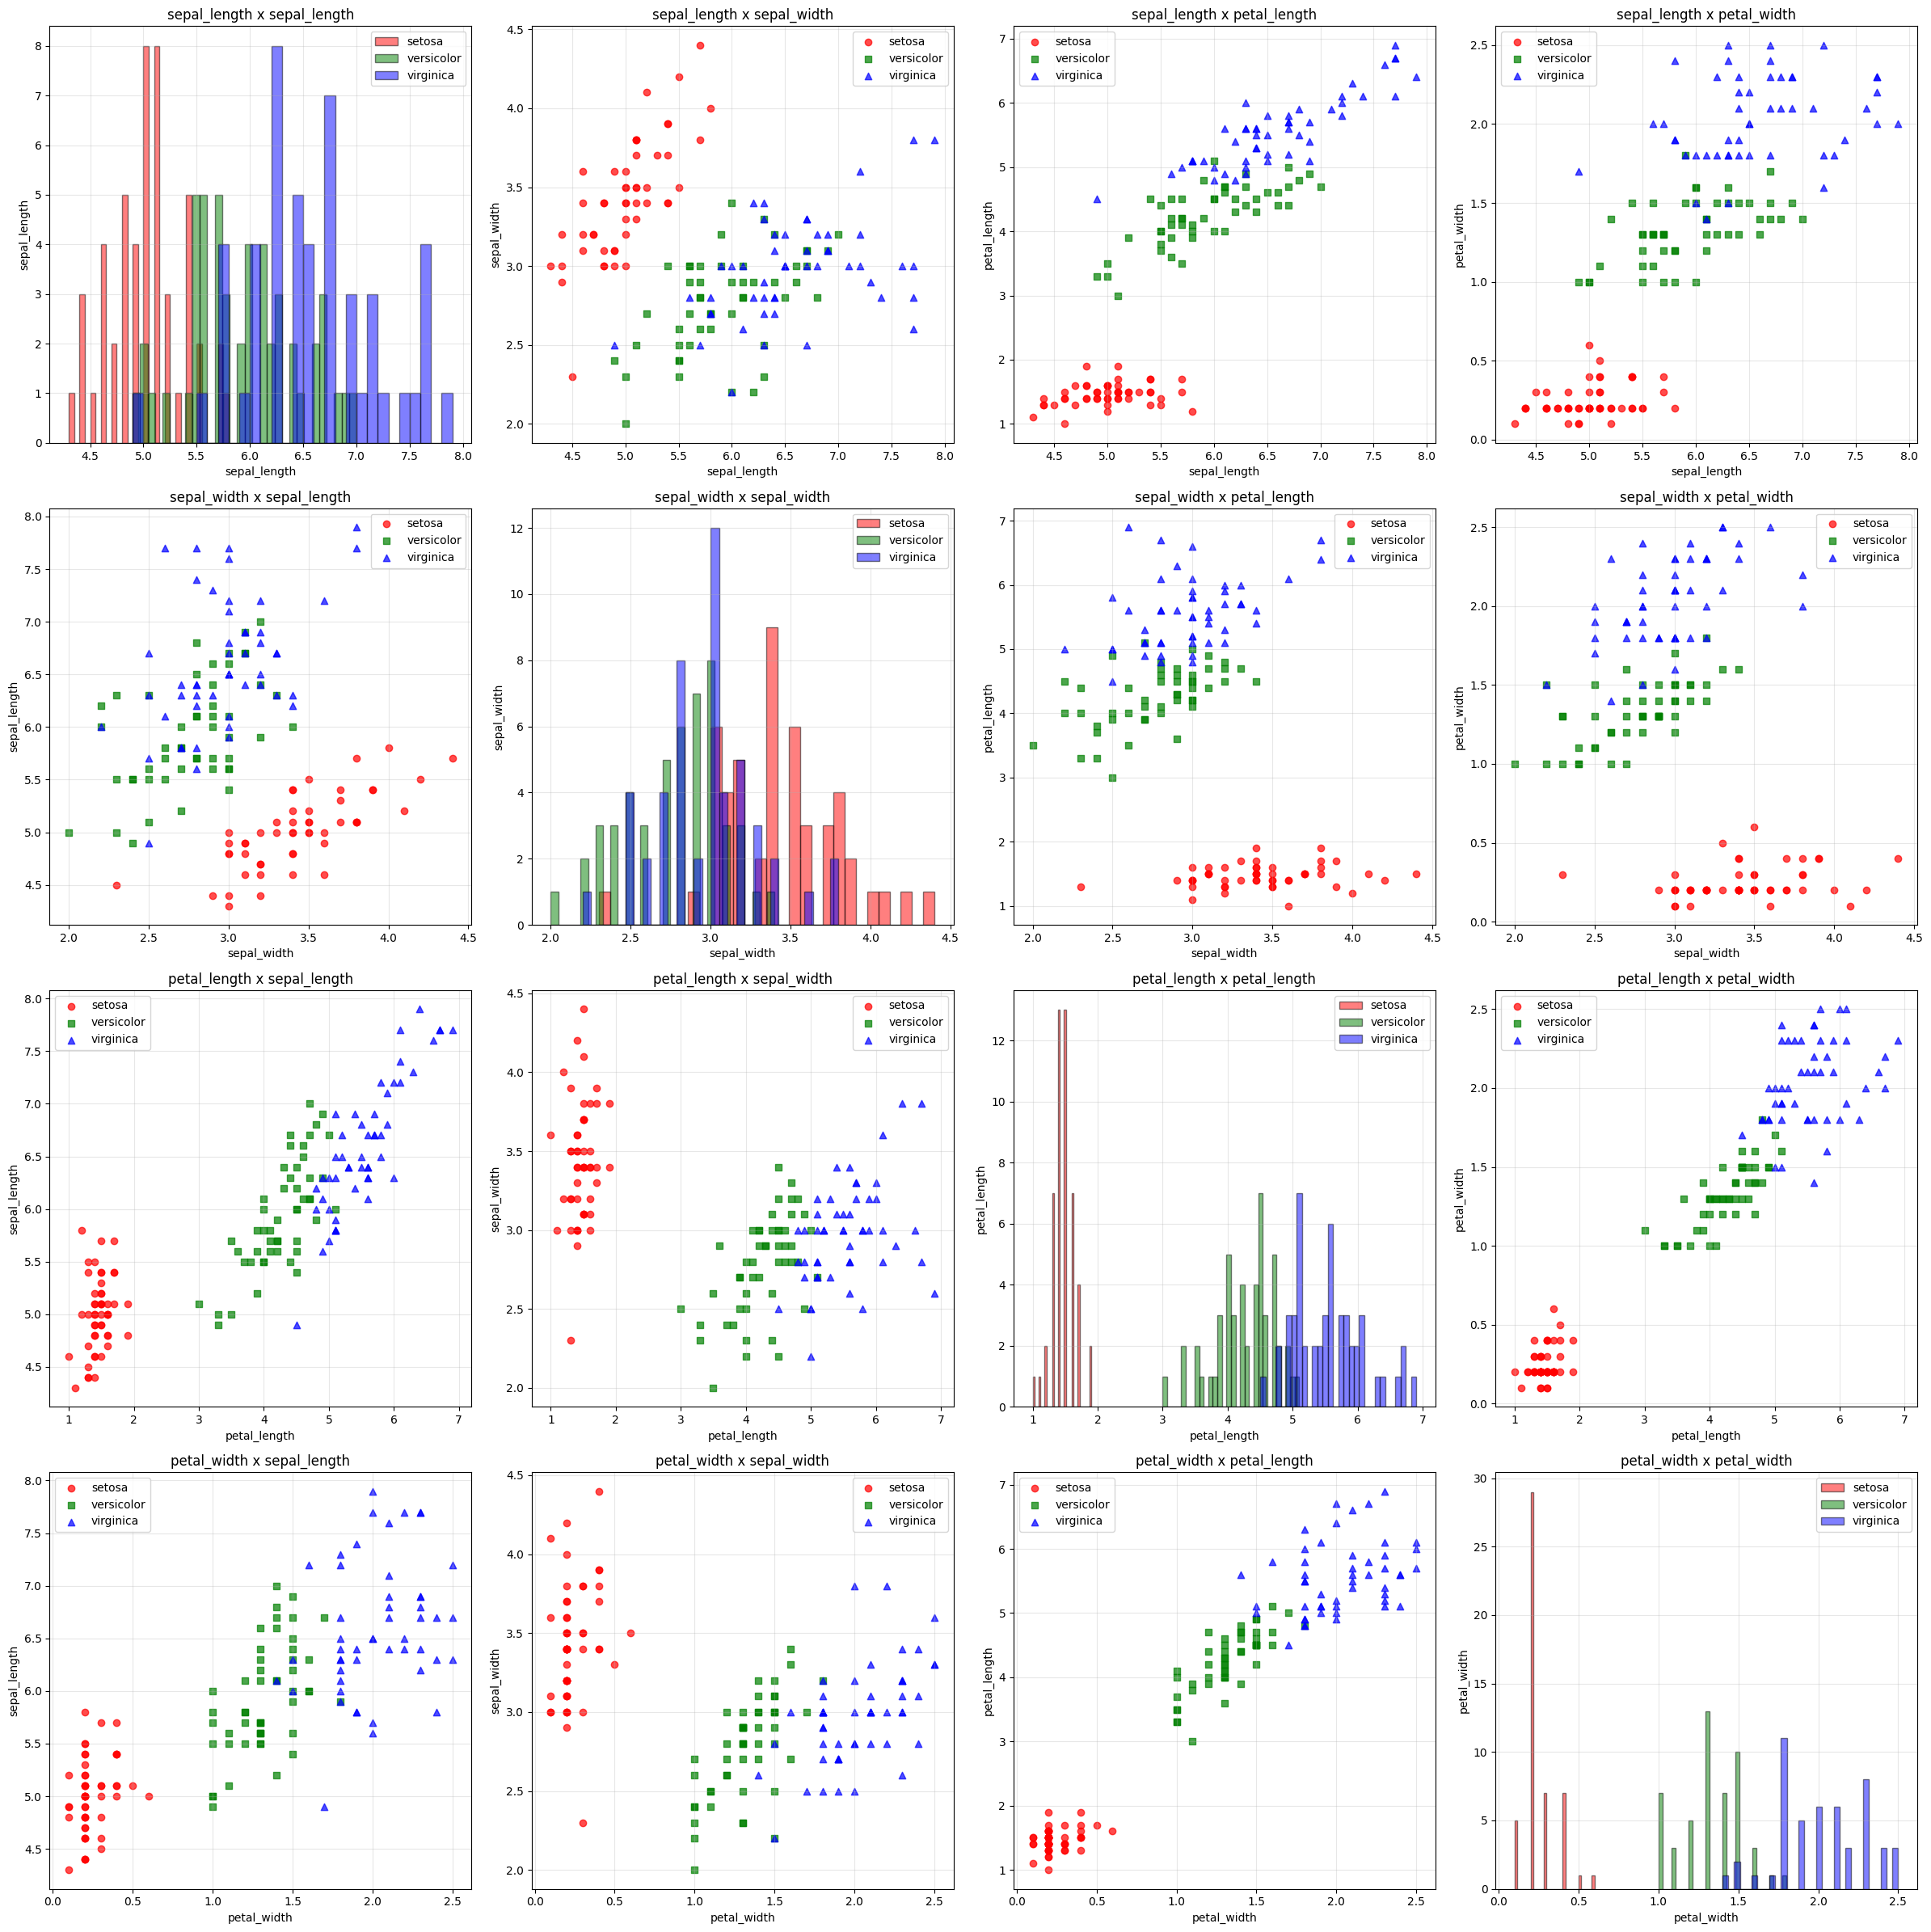

In [5]:
# step4
plotter = Plotter(4, 4, (24, 24))

for i in range(len(main.data)):
    plotter.set_position(idx=i)
    for j, group in enumerate(main.classes):
        if (i // main.params_count) != (i % main.params_count):
            plotter.scatter(main.data_by_class[j][i][..., 0],
                            main.data_by_class[j][i][..., 1],
                            marker=main.styles[j], color=main.colors[j], alpha=0.7, label=group)
        else:
            plotter.hist(main.data_by_class[j][i][..., 0],
                         bins=30, color=main.colors[j], alpha=0.5, edgecolor="black", label=group)
    iparam, jparam = main.params[i // main.params_count], main.params[i % main.params_count]
    plotter.labels(iparam, jparam, f"{iparam} x {jparam}")
    plotter.grid(True, alpha=0.3)
    plotter.legend()
    plotter.del_position()

plotter.tight_layout()
plotter.save("res/scatters1.png", dpi=200)

##### **_Param hists_**

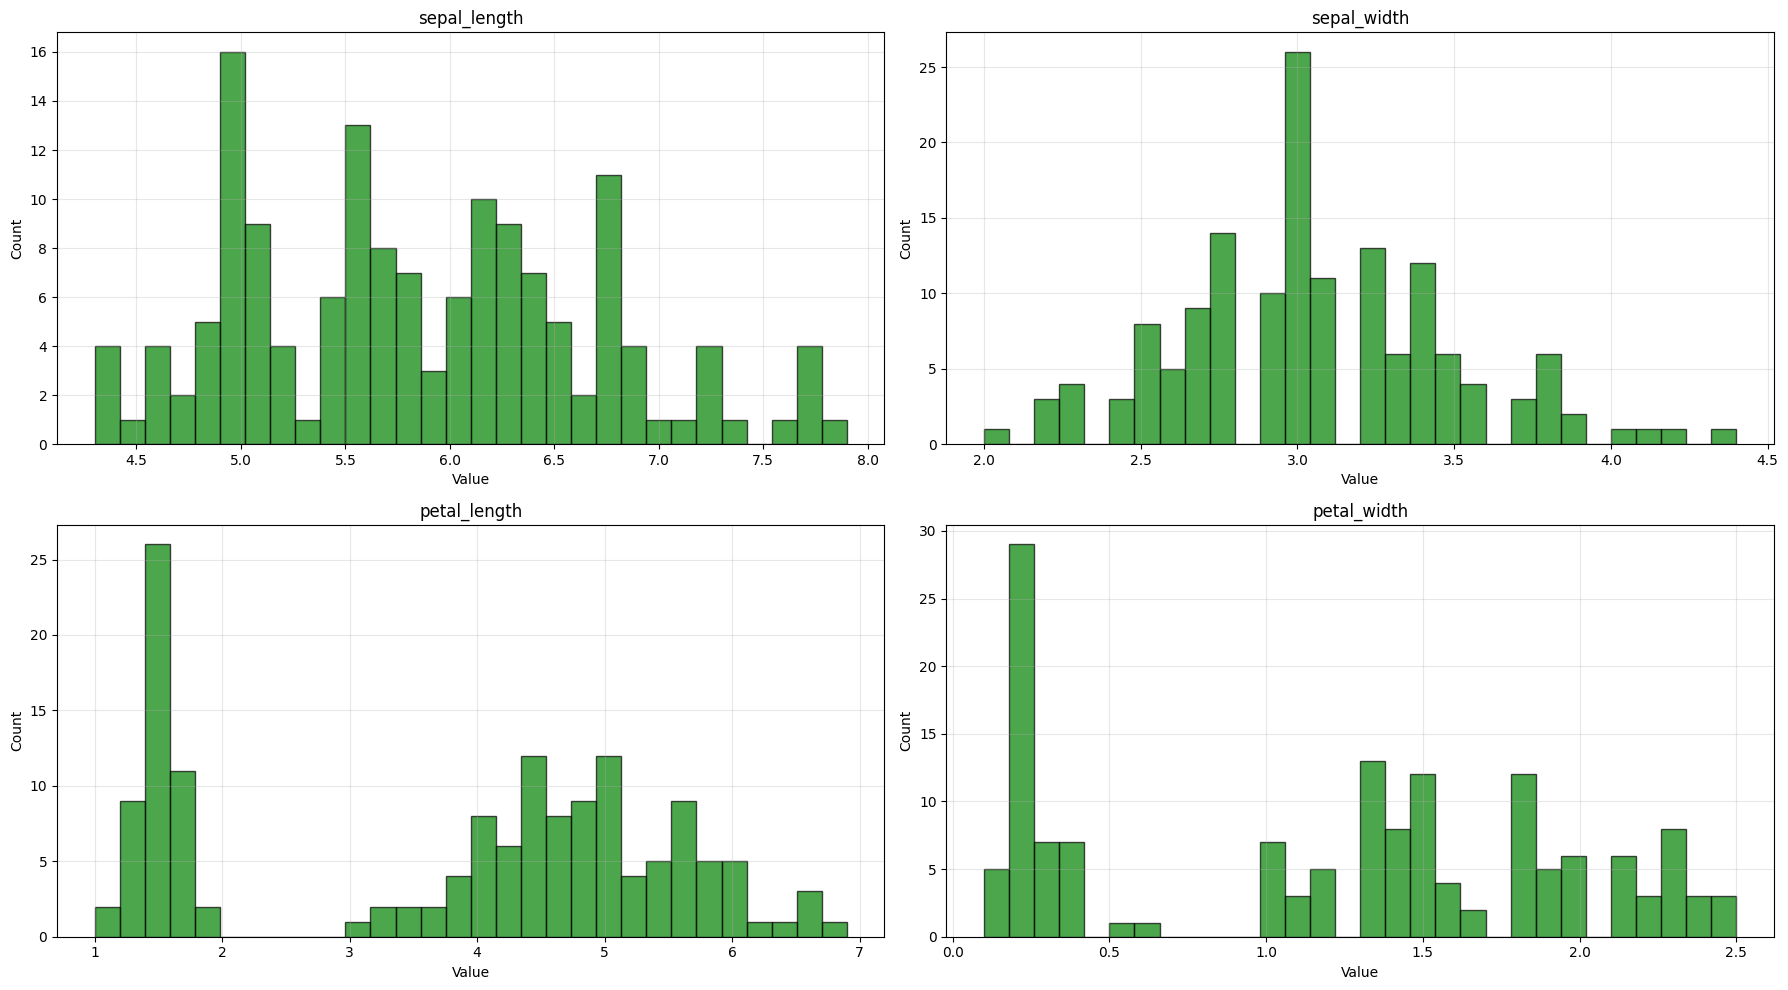

In [6]:
# step5
plotter = Plotter(2, 2, (18, 10))

for j, param in enumerate(main.params):
    plotter.set_position(idx=j)
    plotter.hist(main.iris[param], bins=30, color="green", edgecolor="black", alpha=0.7)
    plotter.labels("Value", "Count", param)
    plotter.grid(True, alpha=0.3)
    plotter.del_position()

plotter.save("res/hists.png", dpi=200)
plotter.tight_layout()

### **Stage 3** (task [4]): _Correlation matrixes_

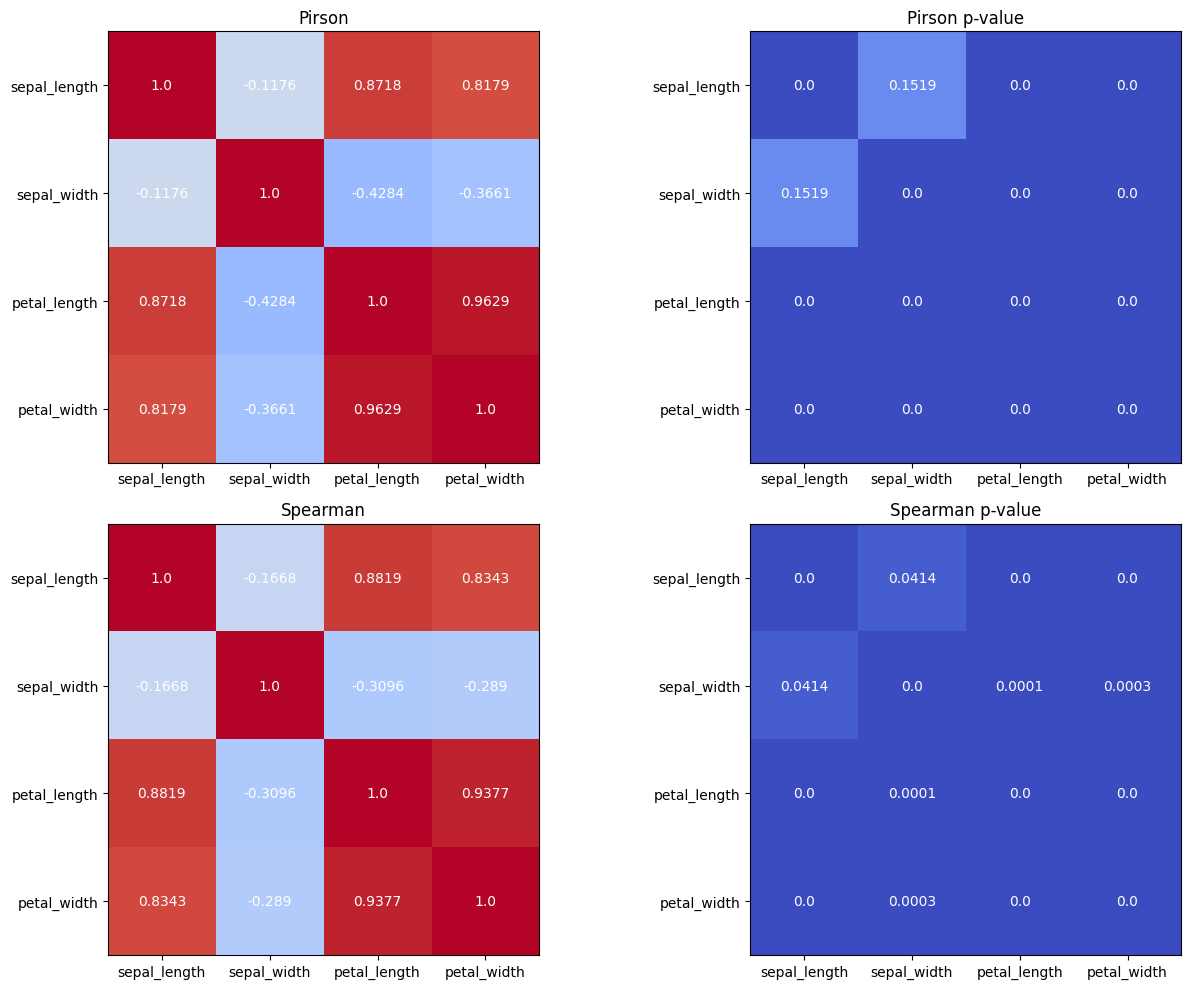

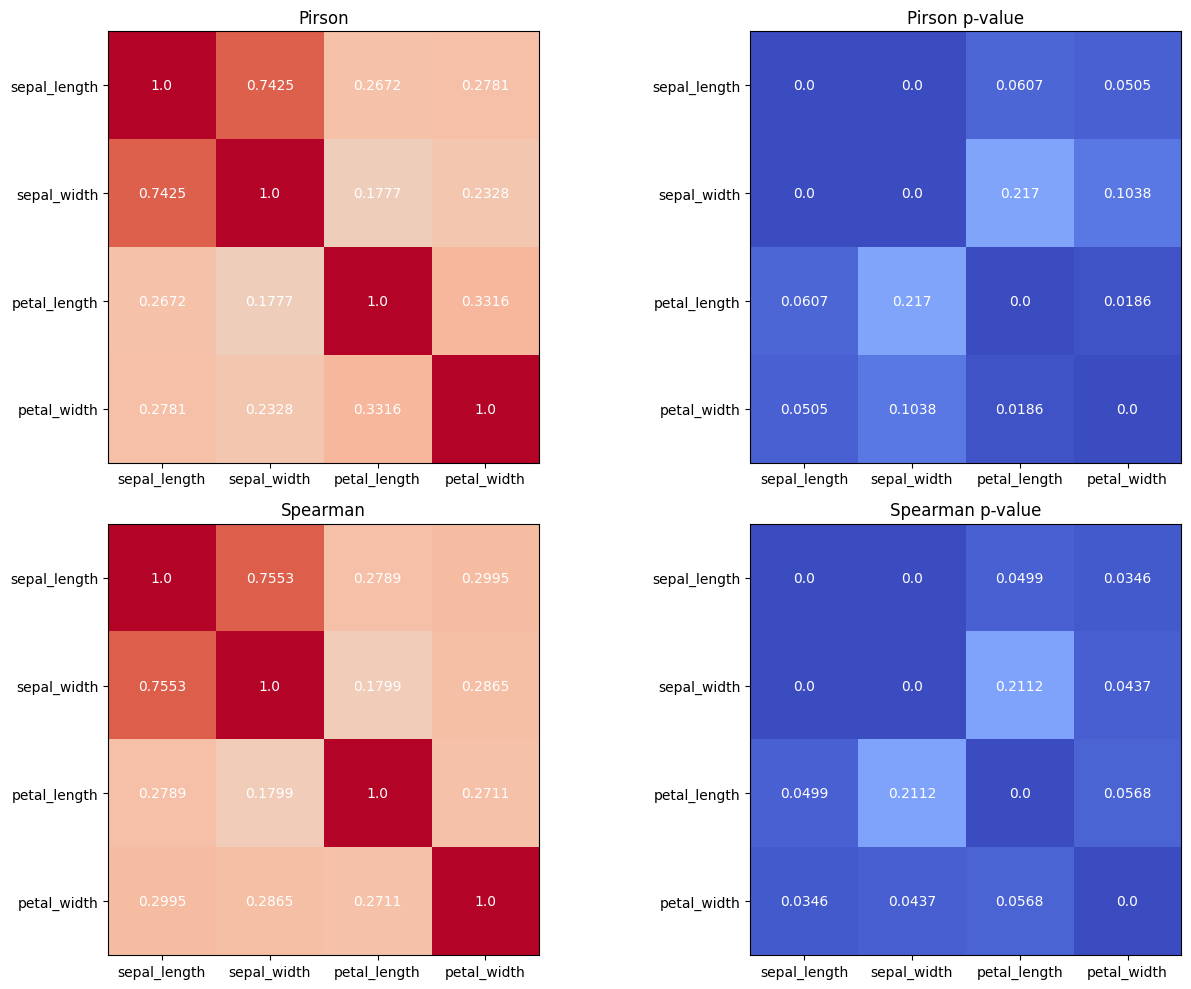

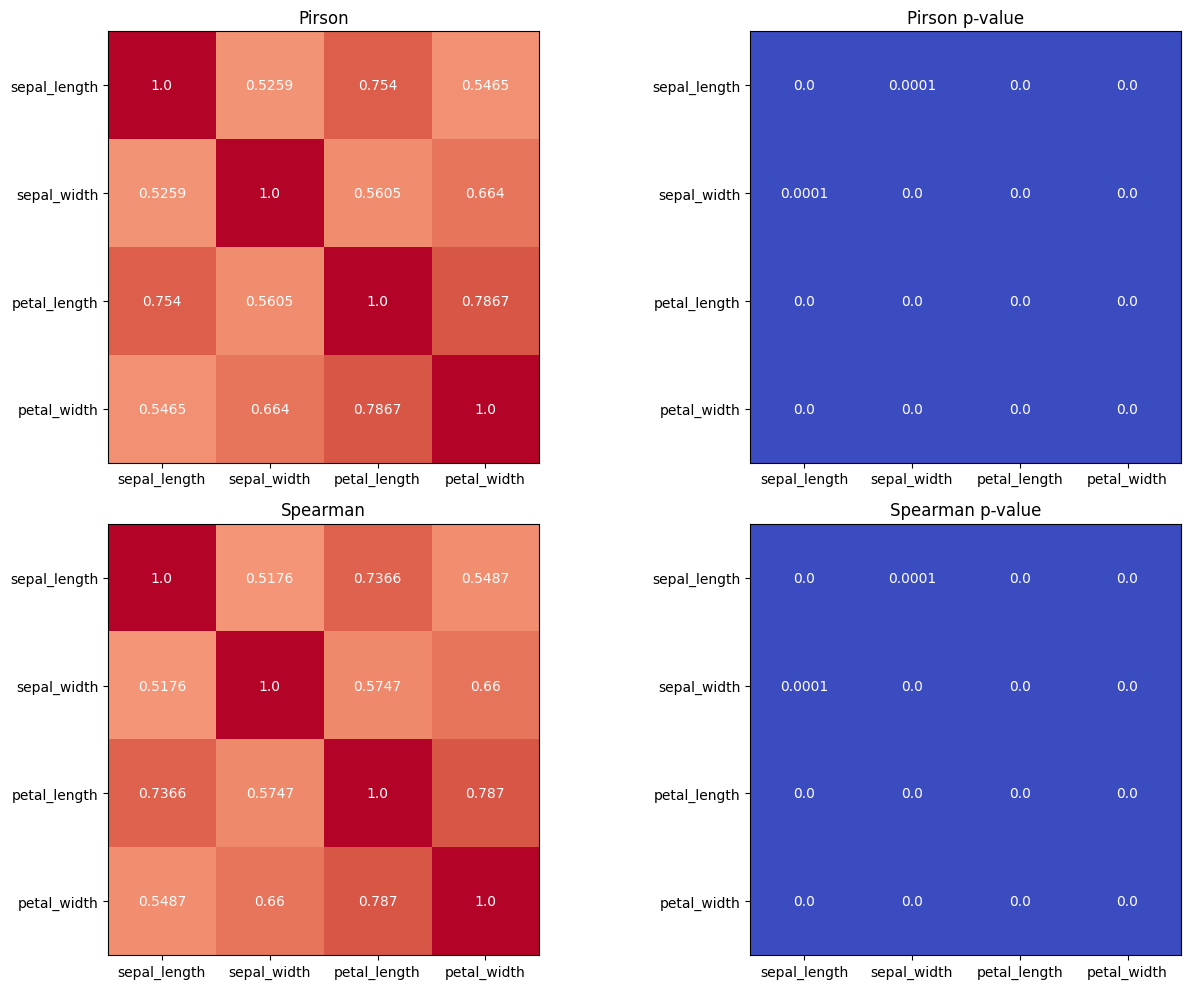

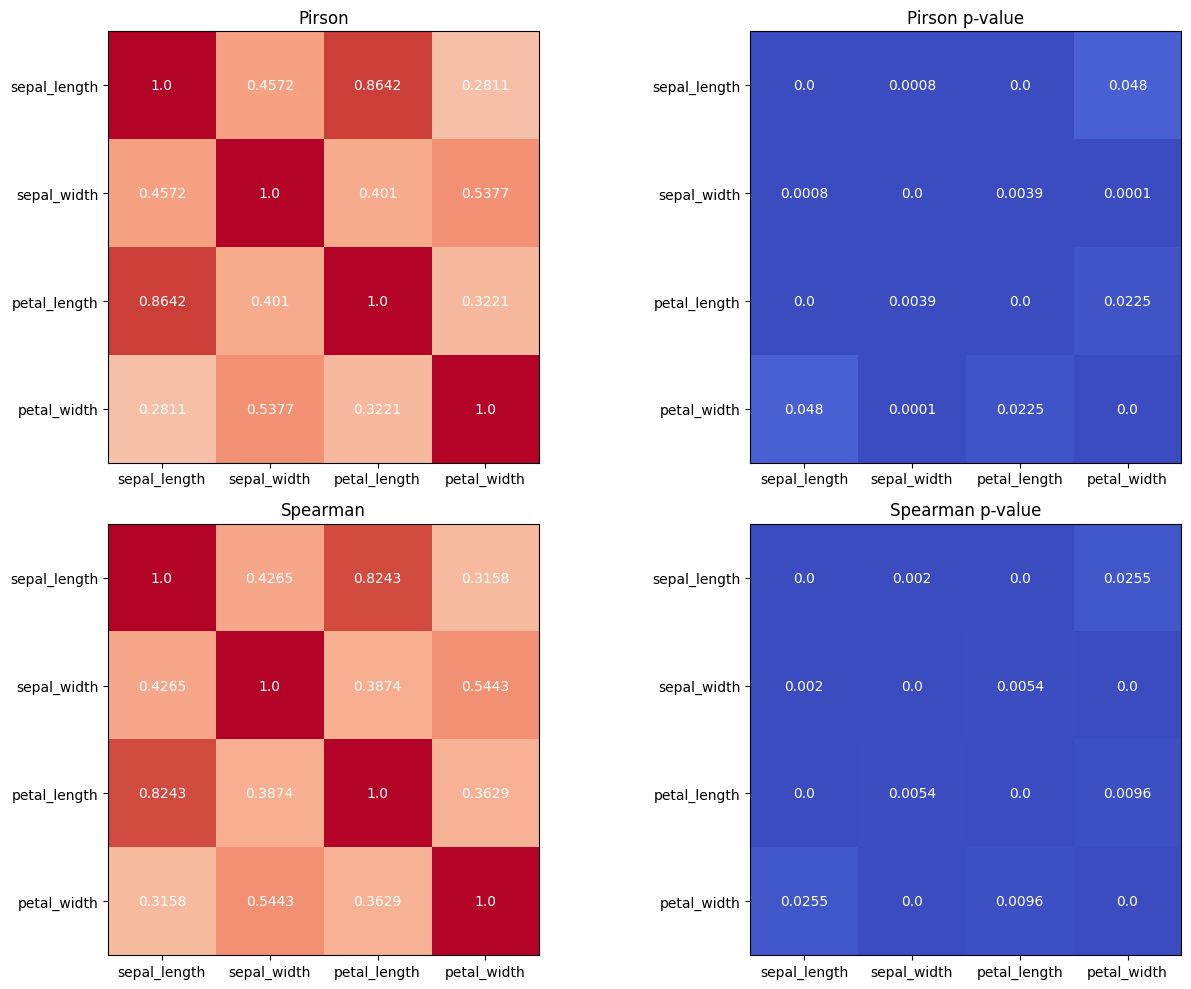

In [7]:
# step6
plotters = [
    Plotter(nrows=2, ncols=2, figsize=(16, 10)),
    Plotter(nrows=2, ncols=2, figsize=(16, 10)),
    Plotter(nrows=2, ncols=2, figsize=(16, 10)),
    Plotter(nrows=2, ncols=2, figsize=(16, 10))
]

for i in range(main.classes_count + 1):
    stats_to_show = main.stats[..., (i * 4):(i + 1) * 4]
    plotter = plotters[i]
    for j, draw_name in enumerate(["Pirson", "Pirson p-value", "Spearman", "Spearman p-value"]):
        plotter.set_position(idx=j)
        if (j + 1) % 2 == 0:
            plotter.imshow(stats_to_show[..., j], vmin=0, vmax=1, cmap="coolwarm")
        else:
            plotter.imshow(stats_to_show[..., j], vmin=-1, vmax=1, cmap="coolwarm")
        for k in range(main.params_count):
            for s in range(main.params_count):
                plotter.text(s, k, np.round(stats_to_show[k, s, j], 4), ha="center", va="center", color="w")
        plotter.set_title(draw_name)
        plotter.set_xticks(np.arange(main.params_count))
        plotter.set_yticks(np.arange(main.params_count))
        plotter.set_xticklabels(main.params)
        plotter.set_yticklabels(main.params)
        plotter.del_position()
        
        plotter.tight_layout()

plotters[0].save("res/stats1.png", dpi=200)
plotters[1].save("res/stats2.png", dpi=200)
plotters[2].save("res/stats3.png", dpi=200)
plotters[3].save("res/stats4.png", dpi=200)

### **Stage 4** (tasks [5] [6] [7]): _Regression and Intervals_

##### **_Calculations and plot drawing_**

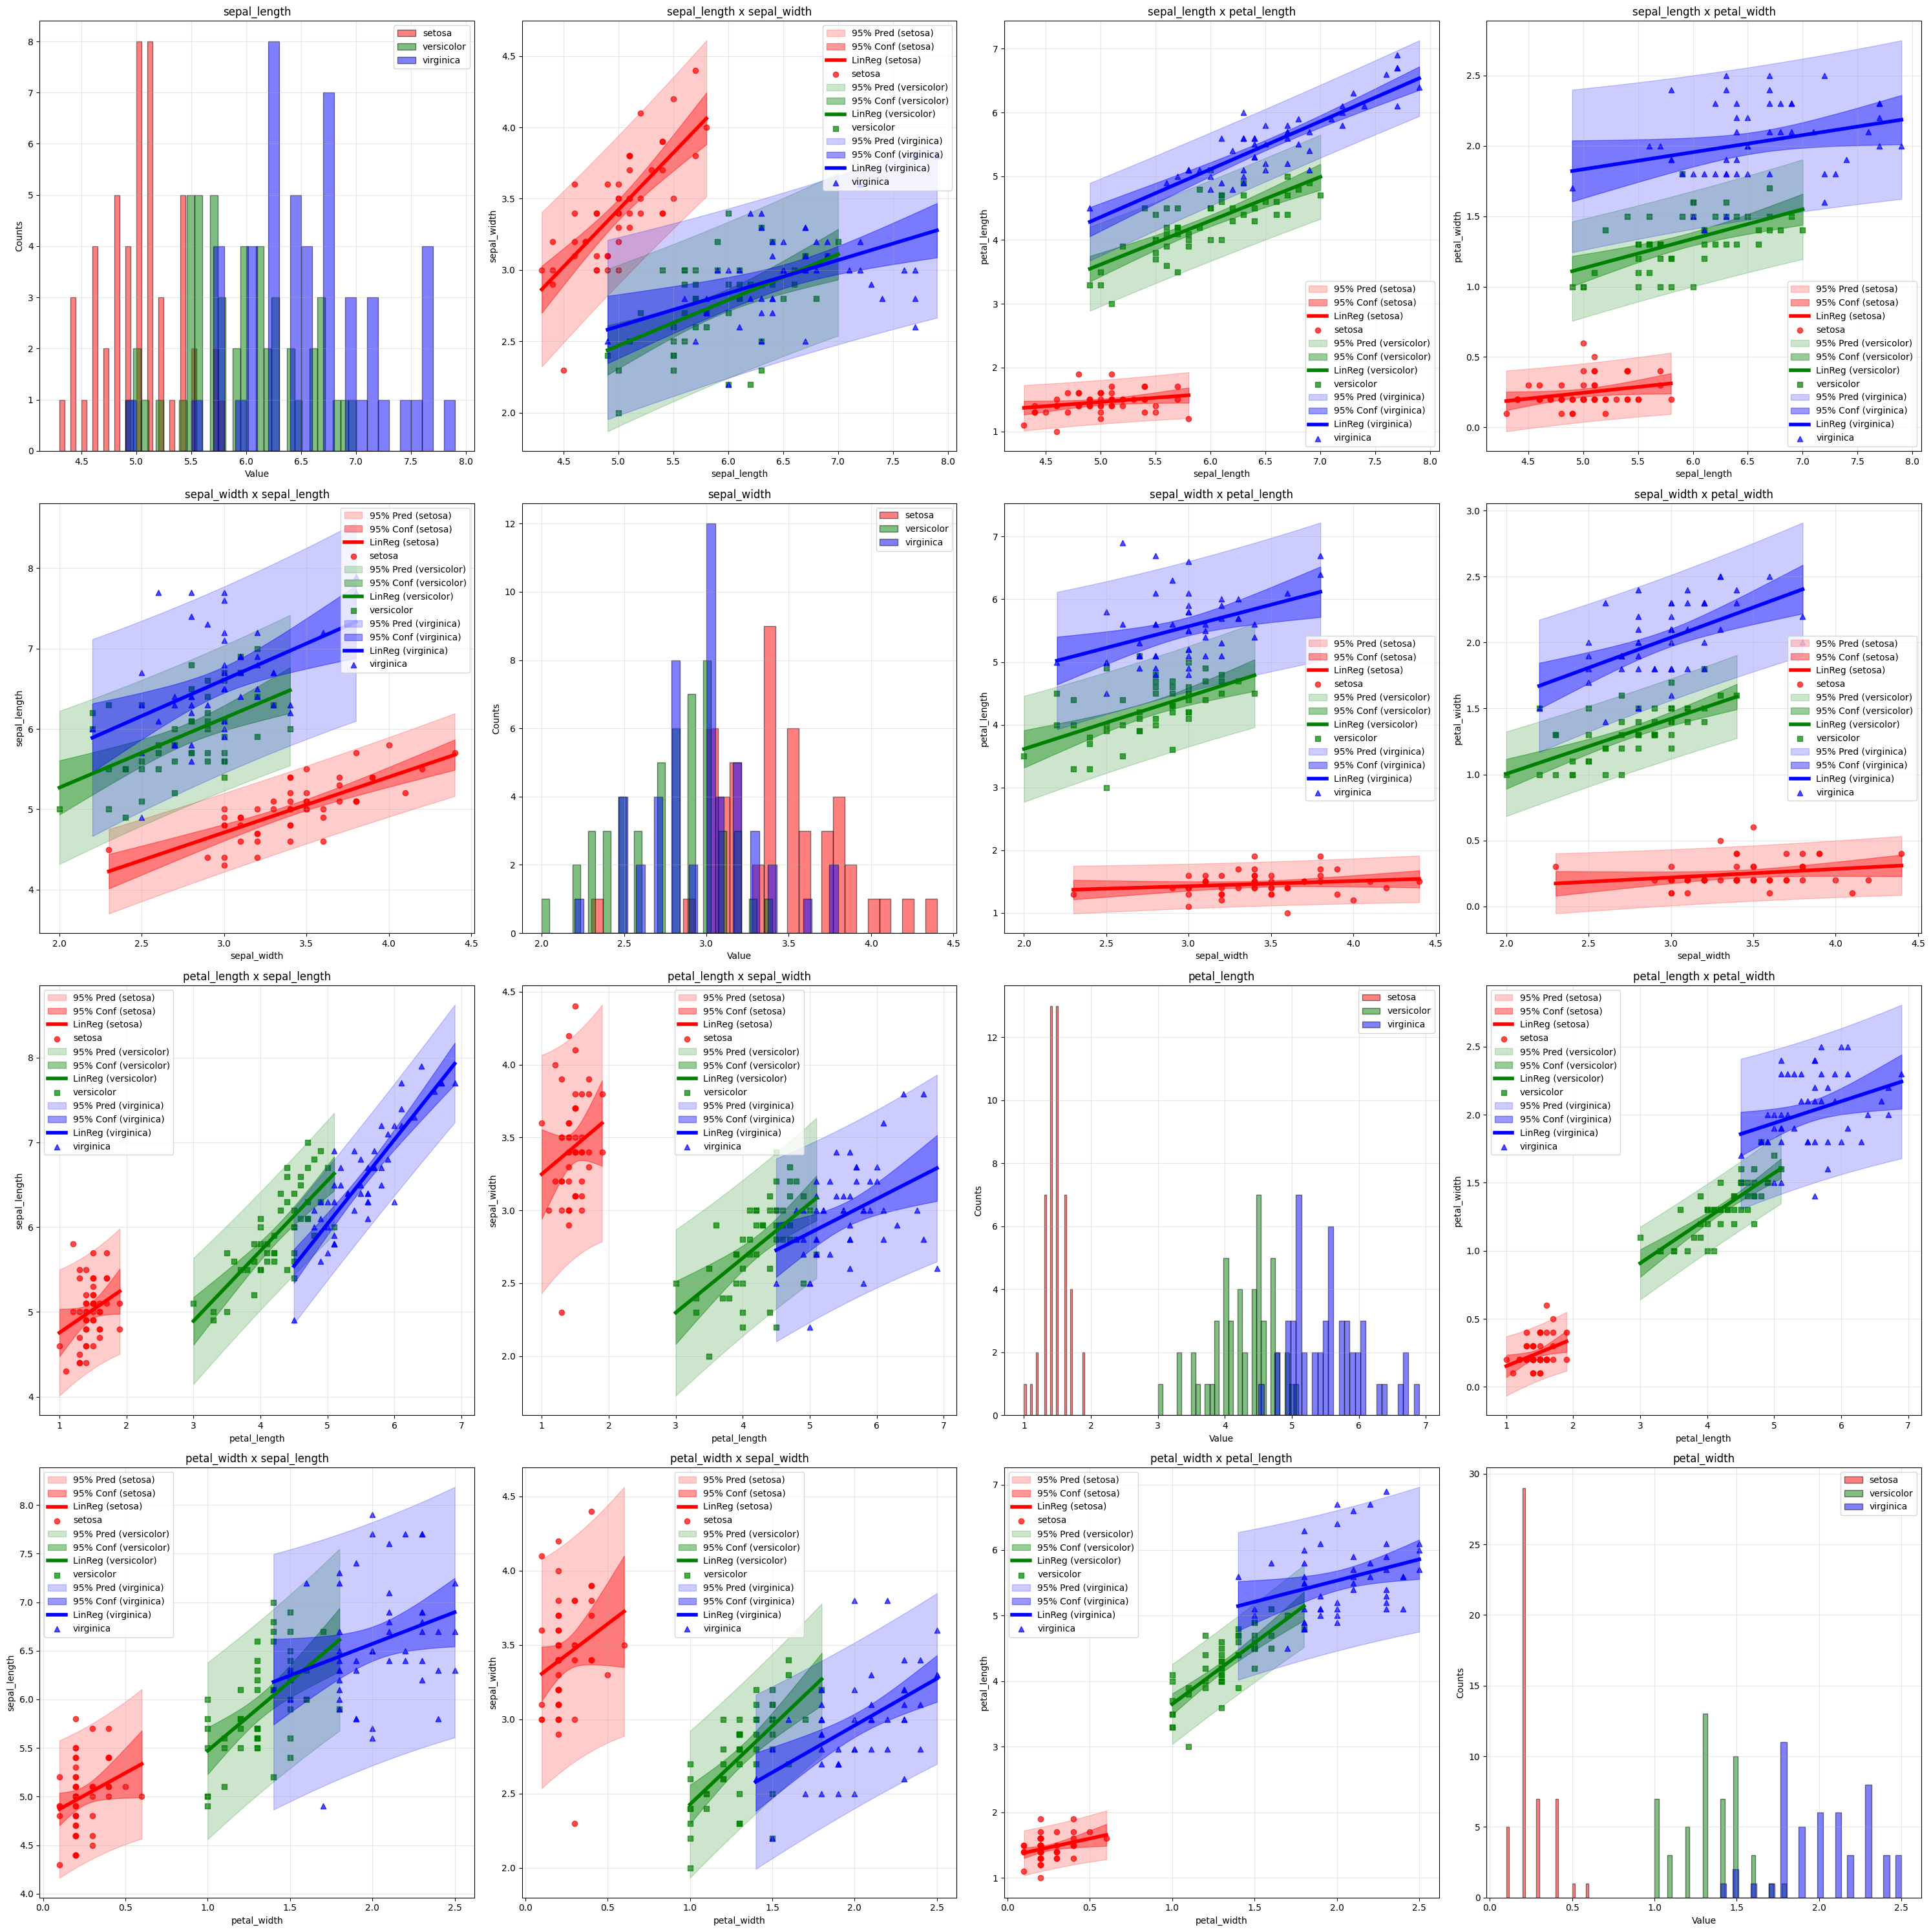

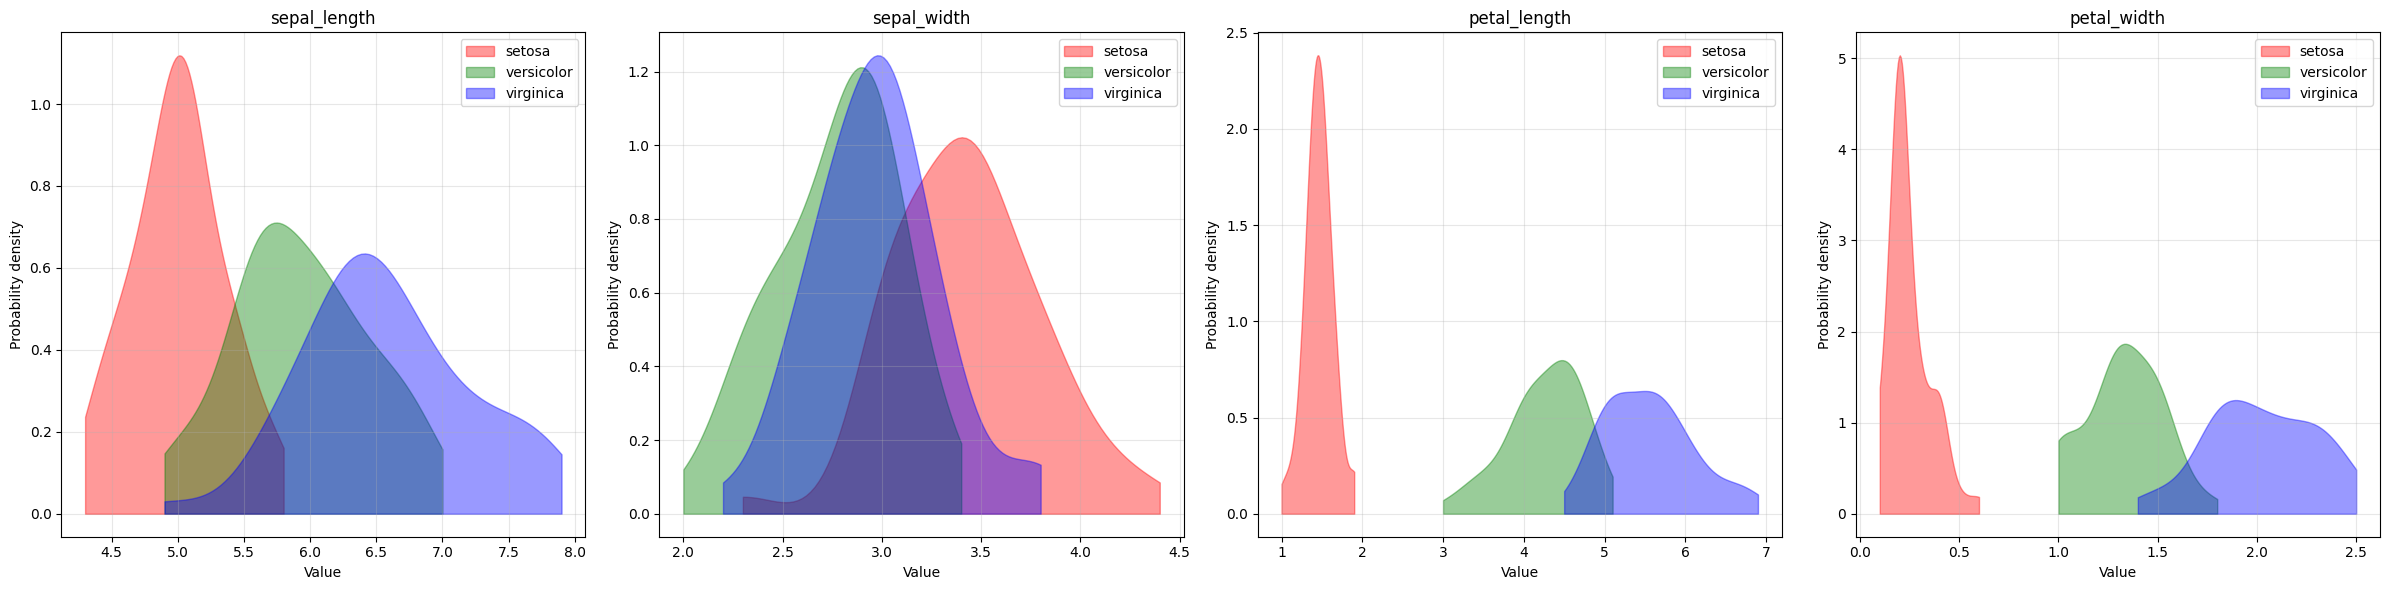

In [13]:
# step7
plotter = Plotter(4, 4, (30, 30))
kde_plotter = Plotter(1, 4, (24, 6))

results = []
idx = 0
for i in range(len(main.data)):
    plotter.set_position(idx=i)
    iparam, jparam = main.params[i // main.params_count], main.params[i % main.params_count]
    for j, group in enumerate(main.classes):
        local_data = main.data_by_class[j][i]
        if (i // main.params_count) != (i % main.params_count):
            x = local_data[..., 0].reshape((local_data.shape[0], 1))
            y = local_data[..., 1]
            
            x_const = sm.add_constant(x)

            model_full = sm.OLS(y, x_const).fit()
            model_restricted = sm.OLS(y, np.ones((len(y), 1))).fit()
            
            lr_statistic, lr_pvalue, lr_df = model_full.compare_lr_test(model_restricted)
            
            intercept, slope = model_full.params
            formula = f"{jparam} = {slope:.4f} * {iparam} + {intercept:.4f}"
            
            results.append({
                'X_variable': iparam,
                'Y_variable': jparam,
                'Slope': slope,
                'Intercept': intercept,
                'Class': group,
                'Formula': formula,
                'R_squared': model_full.rsquared,
                'F_statistic': model_full.fvalue,
                'F_df_num': model_full.df_model,
                'F_df_denom': model_full.df_resid,
                'F_pvalue': model_full.f_pvalue,
                'LR_chi2': lr_statistic,
                'LR_pvalue': lr_pvalue,
                "LR_df": lr_df
            })
            
            x_plot = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
            x_plot_with_const = sm.add_constant(x_plot)
            
            predictions = model_full.get_prediction(x_plot_with_const)
            frame = predictions.summary_frame(alpha=0.05)
            
            y_pred = frame['mean']
            ci_lower = frame['mean_ci_lower']
            ci_upper = frame['mean_ci_upper']
            pi_lower = frame['obs_ci_lower']
            pi_upper = frame['obs_ci_upper']
            
            plotter.fill_between(x_plot.flatten(), pi_lower, pi_upper, 
                           color=main.colors[j], alpha=0.2, 
                           label=f'95% Pred ({main.classes[j]})')
            
            plotter.fill_between(x_plot.flatten(), ci_lower, ci_upper, 
                           color=main.colors[j], alpha=0.4,
                           label=f'95% Conf ({main.classes[j]})')
            
            plotter.plot(x_plot,
                            y_pred,
                            linewidth=4,
                            color=main.colors[j],
                            label=f"LinReg ({main.classes[j]})")

            plotter.scatter(local_data[..., 0],
                            local_data[..., 1],
                            marker=main.styles[j], color=main.colors[j], alpha=0.7, label=group)
        else:
            plotter.hist(local_data[..., 0],
                         bins=30, color=main.colors[j], alpha=0.5, edgecolor="black", label=group)
            kde = scipy.stats.gaussian_kde(local_data[..., 0])
            x = np.linspace(local_data[..., 0].min(), local_data[..., 0].max(), 100)
            kde_plotter.set_position(idx=idx)
            kde_plotter.fill_between(x, np.zeros_like(x), kde(x), color=main.colors[j], alpha=0.4, label=group)

    if (i // main.params_count) != (i % main.params_count):
        plotter.labels(iparam, jparam, f"{iparam} x {jparam}")
    else:
        plotter.labels("Value", "Counts", iparam)
    plotter.grid(True, alpha=0.3)
    plotter.legend()
    plotter.del_position()

    if i % 5 == 0:
        kde_plotter.labels("Value", "Probability density", iparam)
        kde_plotter.grid(True, alpha=0.3)
        kde_plotter.legend()
        kde_plotter.del_position()
        idx += 1

plotter.tight_layout()
plotter.save("res/scatters2.png", dpi=200)
kde_plotter.tight_layout()
kde_plotter.save("res/kde.png", dpi=200)

res_df = pd.DataFrame(results)

##### **_Task 7 results table_**

In [ ]:
res_df.to_csv("res/regression_stats.csv", index=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

res_df

,X_variable,Y_variable,Slope,Intercept,Class,Formula,R_squared,F_statistic,F_df_num,F_df_denom,F_pvalue,LR_chi2,LR_pvalue,LR_df
0,sepal_length,sepal_width,0.798528,-0.569433,setosa,sepal_width = 0.7985 * sepal_length + -0.5694,0.551376,58.993730,1.0,48.0,6.709843e-10,40.078461,2.439642e-10,1.0
1,sepal_length,sepal_width,0.319719,0.872146,versicolor,sepal_width = 0.3197 * sepal_length + 0.8721,0.276582,18.351688,1.0,48.0,8.771860e-05,16.188410,5.734390e-05,1.0
2,sepal_length,sepal_width,0.231890,1.446305,virginica,sepal_width = 0.2319 * sepal_length + 1.4463,0.209057,12.687074,1.0,48.0,8.434625e-04,11.726486,6.161682e-04,1.0
3,sepal_length,petal_length,0.131632,0.803052,setosa,petal_length = 0.1316 * sepal_length + 0.8031,0.071383,3.689765,1.0,48.0,6.069778e-02,3.702939,5.431672e-02,1.0
4,sepal_length,petal_length,0.686470,0.185116,versicolor,petal_length = 0.6865 * sepal_length + 0.1851,0.568590,63.263024,1.0,48.0,2.586190e-10,42.034799,8.966350e-11,1.0
5,sepal_length,petal_length,0.750081,0.610468,virginica,petal_length = 0.7501 * sepal_length + 0.6105,0.746884,141.636664,1.0,48.0,6.297786e-16,68.695447,1.149059e-16,1.0
6,sepal_length,petal_width,0.083144,-0.170221,setosa,petal_width = 0.0831 * sepal_length + -0.1702,0.077339,4.023424,1.0,48.0,5.052644e-02,4.024653,4.483984e-02,1.0
7,sepal_length,petal_width,0.209357,0.083256,versicolor,petal_width = 0.2094 * sepal_length + 0.0833,0.298620,20.436482,1.0,48.0,4.035422e-05,17.735252,2.538781e-05,1.0
8,sepal_length,petal_width,0.121416,1.226108,virginica,petal_width = 0.1214 * sepal_length + 1.2261,0.079022,4.118483,1.0,48.0,4.798149e-02,4.115932,4.248112e-02,1.0
9,sepal_width,sepal_length,0.690490,2.639001,setosa,sepal_length = 0.6905 * sepal_width + 2.6390,0.551376,58.993730,1.0,48.0,6.709843e-10,40.078461,2.439642e-10,1.0


### **Stage 5** (tasks [8] [9]):

In [30]:
for i, param in enumerate(main.params):
    values = main.iris[param]
    groups = main.iris["species"]
    f_stat, p_value = scipy.stats.f_oneway(*[values[groups == group] for group in main.classes])
    
    df_between = main.classes_count - 1
    df_within = len(values) - main.classes_count
    
    print()
    print("Stats for", param)
    print("=" * 60)
    print("F-stat:", f_stat)
    print("p-value", p_value)
    print("DF:", df_between, df_within)
    print()
    
    tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=values, groups=groups, alpha=0.5)
    
    print(tukey.summary())
    print("=" * 60 + "\n")


Stats for sepal_length
F-stat: 119.26450218450472
p-value 1.6696691907693648e-31
DF: 2 147

   Multiple Comparison of Means - Tukey HSD, FWER=0.50   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor     0.93   0.0 0.8141 1.0459   True
    setosa  virginica    1.582   0.0 1.4661 1.6979   True
versicolor  virginica    0.652   0.0 0.5361 0.7679   True
---------------------------------------------------------


Stats for sepal_width
F-stat: 49.160040089612075
p-value 4.492017133309115e-17
DF: 2 147

    Multiple Comparison of Means - Tukey HSD, FWER=0.50     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    setosa versicolor   -0.658    0.0 -0.7345 -0.5815   True
    setosa  virginica   -0.454    0.0 -0.5305 -0.3775   True
versicolor  virginica    0.204 0.0088  0.1275  0.2805   True
-------------------------------------------

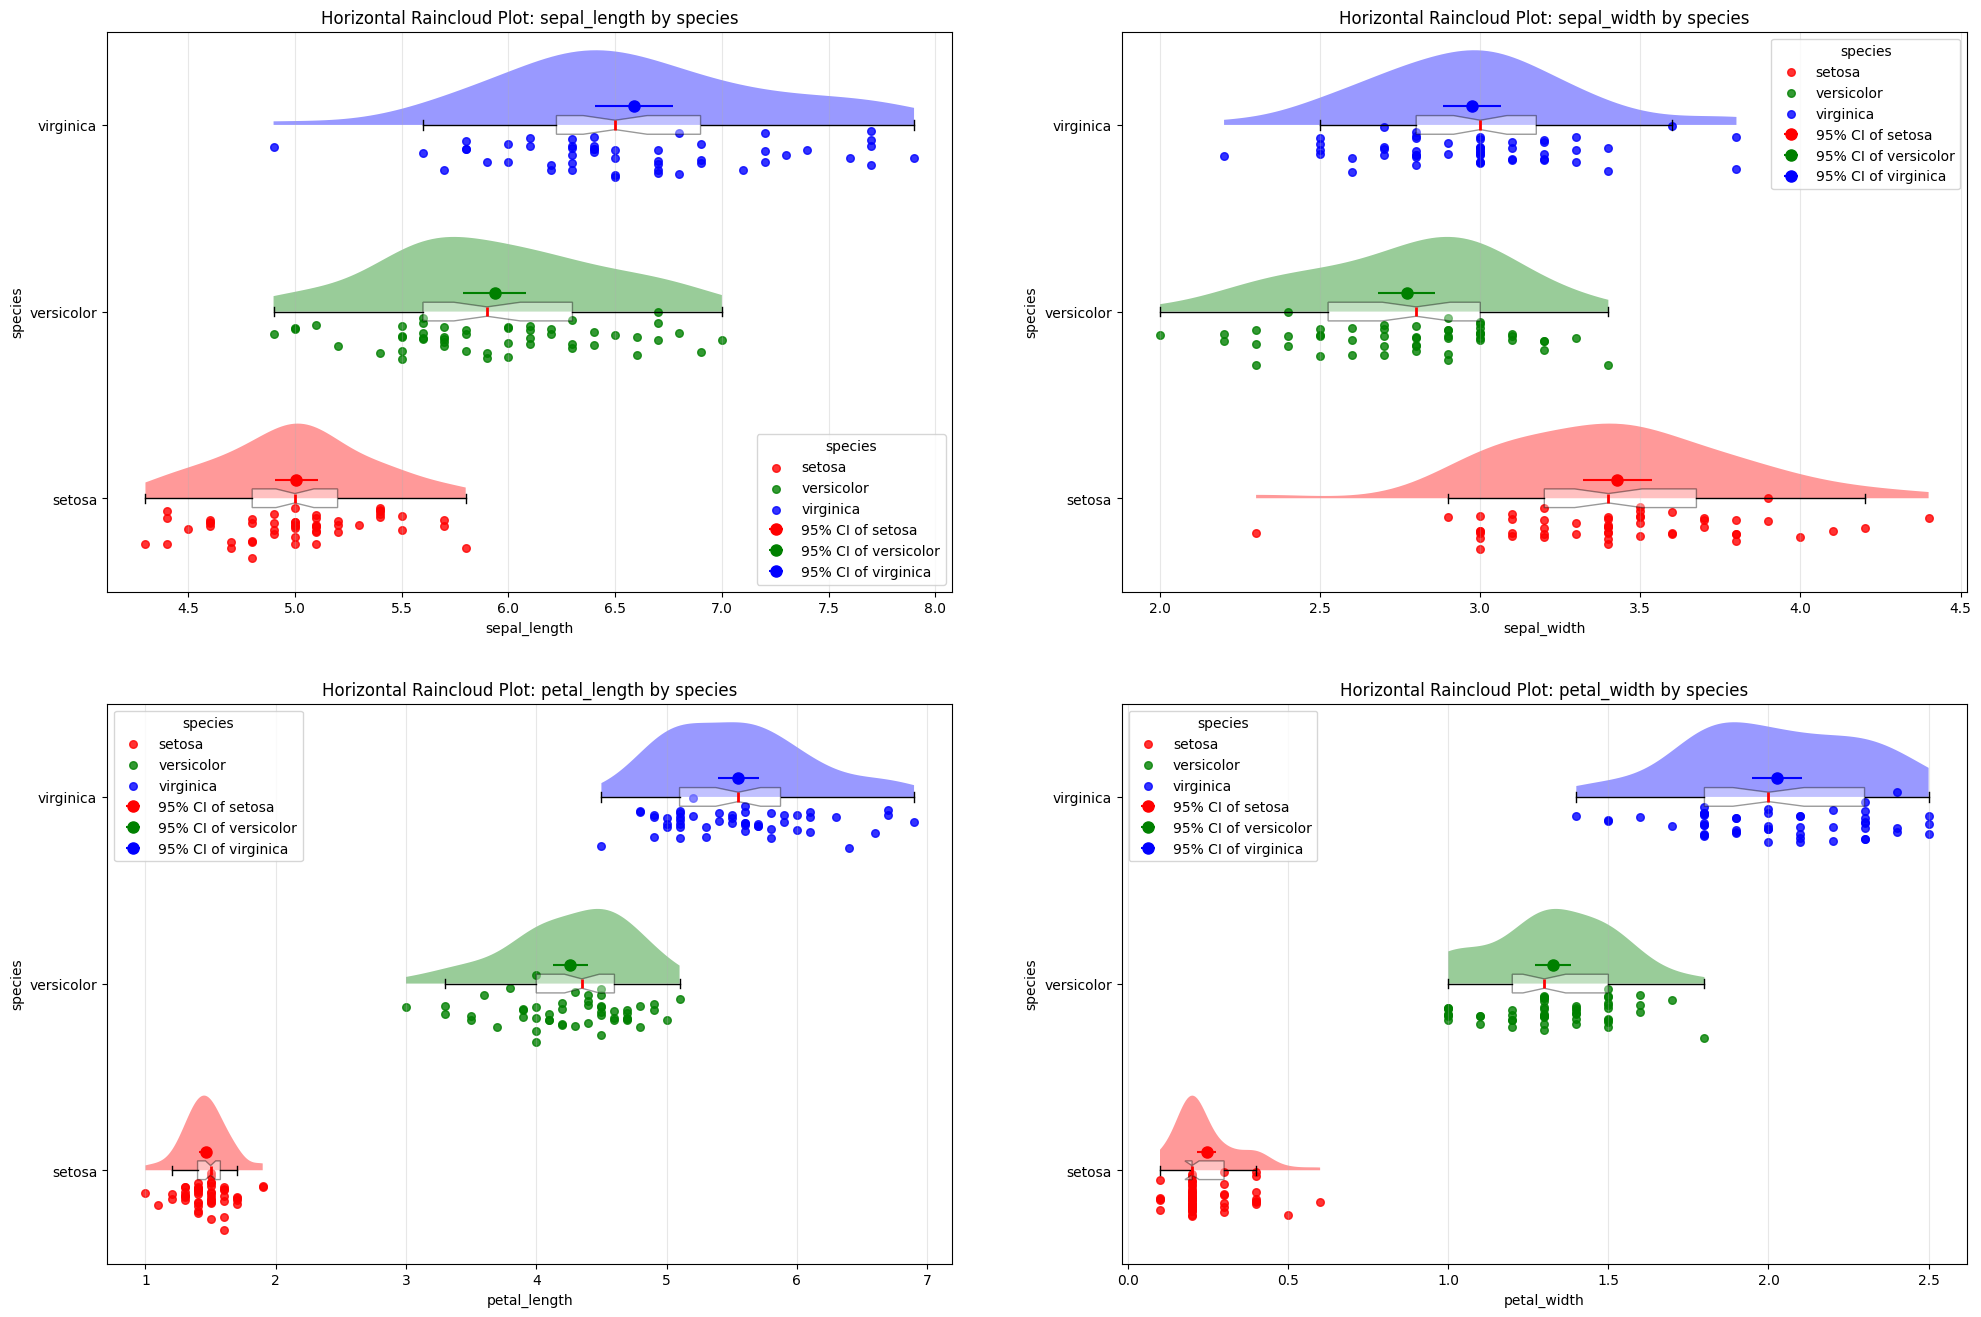

In [ ]:
plotter = Plotter(2, 2, (24, 16))

for i, param in enumerate(main.params):
    plotter.raincloud_plot(main.iris, param, "species", main.classes, colors=main.colors, idx=i)

plotter.save("res/raincloud_plots.png", dpi=200)